In [85]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *
from src.utils.dates import get_today, lag_date, date2str, str2date, get_format
from src.utils.df_utils import get_date_columns
from src.pandas.align import align_lagged_dates

from scipy.stats import spearmanr

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
# Time series data
mobility, mobility_date = load_google_mobility()
deaths, deaths_date = load_deaths(join_county_codes=False)
interventions, interventions_date = load_interventions()

# Static data
counties, counties_date = load_counties()

# Processed mobility -> time series
mobility_ts, mobility_ts_date = load_google_mobility_time_series()

m50,_ = load_descartes_m50()

od_mobility = load_od_baseline()

hospitals = load_acute_care(beds=True)

print(f'Mobility Last Updated {mobility_ts_date}')
print(f'Deaths Last Updated {deaths_date}')

Mobility Last Updated 05-08
Deaths Last Updated 05-26


In [63]:
death_dates = get_date_columns(mobility_ts, return_dtimes=False)

In [64]:
def get_onset_date(row, thresh = 5):
    above = row[row > thresh]
    if len(above) == 0:
        return np.nan
    else:
        return above.idxmin()

In [65]:
## Normalize deaths by pop total
deaths_df = deaths[['FIPS']+death_dates]

deaths_df['onset'] = deaths_df[death_dates].apply(lambda row: get_onset_date(row), axis=1)

## New date range
deaths_df = deaths_df.dropna(axis=0, subset=['onset'])

n_days = 28
deaths_df = deaths_df[deaths_df['onset'].apply(lambda d: (str2date(death_dates[-1]) - str2date(d)).days >= n_days)]
# deaths_df = deaths_df[deaths_df['onset'].apply(lambda d: (str2date(death_dates[-1]) - str2date(d)).days >= n_days)]
deaths_df['cum_deaths'] = deaths_df.apply(
    lambda r: sum(r[[d for d in death_dates if 
        str2date(d) >= str2date(r['onset']) and 
        str2date(d) < lag_date(str2date(r['onset']
    ), 
    lag=n_days, backwards=False)]]), axis=1)

In [66]:
def normalize(row, cols, target='cum_deaths'):
    """
    Normalizes target column by column cols
    norm_type : list of len(cols)
     - 1 to multiply target by (i.e. density)
     - -1 to divide target by (i.e. total pop)
    """
    r = row[target]
    for col,norm_type in cols.items():
        if pd.isnull(row[col]):
            r = np.nan
            break
        r *= int(row[col])**(norm_type)

    return r

In [73]:
cum_deaths = deaths_df[['FIPS', 'cum_deaths']]
cum_deaths = pd.merge(cum_deaths, hospitals, on='FIPS')

m50_dates = get_date_columns(m50, return_dtimes=False)
m50['baseline'] = m50.apply(lambda x: x[m50_dates[:7]].mean(), axis=1)
cum_deaths = pd.merge(cum_deaths, m50[['FIPS', 'baseline']], on='FIPS')
cum_deaths.rename(columns={'baseline':'m50'}, inplace=True)
cum_deaths = pd.merge(cum_deaths, od_mobility, on='FIPS')

confounder_dict = {
    'POP_ESTIMATE_2018' : -1,
    'Density per square mile of land area - Population': -1,
    'Rural-urban_Continuum Code_2013': 0,
    'Total_age65plus': 0,
}
cum_deaths = pd.merge(cum_deaths, counties[['FIPS'] + list(confounder_dict.keys())], on='FIPS')
cum_deaths['normalized_deaths'] = cum_deaths.apply(
    lambda row: normalize(row, confounder_dict), axis=1
    )
for col in ['inter_movement', 'in_movement', 'out_movement']:
    cum_deaths[col] = cum_deaths.apply(lambda row: row[col] / row['POP_ESTIMATE_2018'], axis=1)

cum_deaths.dropna(axis=0, inplace=True)

In [74]:
log_cols = ['normalized_deaths', 'HospCt', 'm50', 'Beds', 'inter_movement', 'in_movement', 'out_movement','Density per square mile of land area - Population']
# cum_deaths['Beds'] = cum_deaths['Beds'] + 1
# cum_deaths['HospCt'] = cum_deaths['HospCt'] + 1
cum_deaths[[lc + ' (log)' for lc in log_cols]] = cum_deaths[log_cols].transform('log')

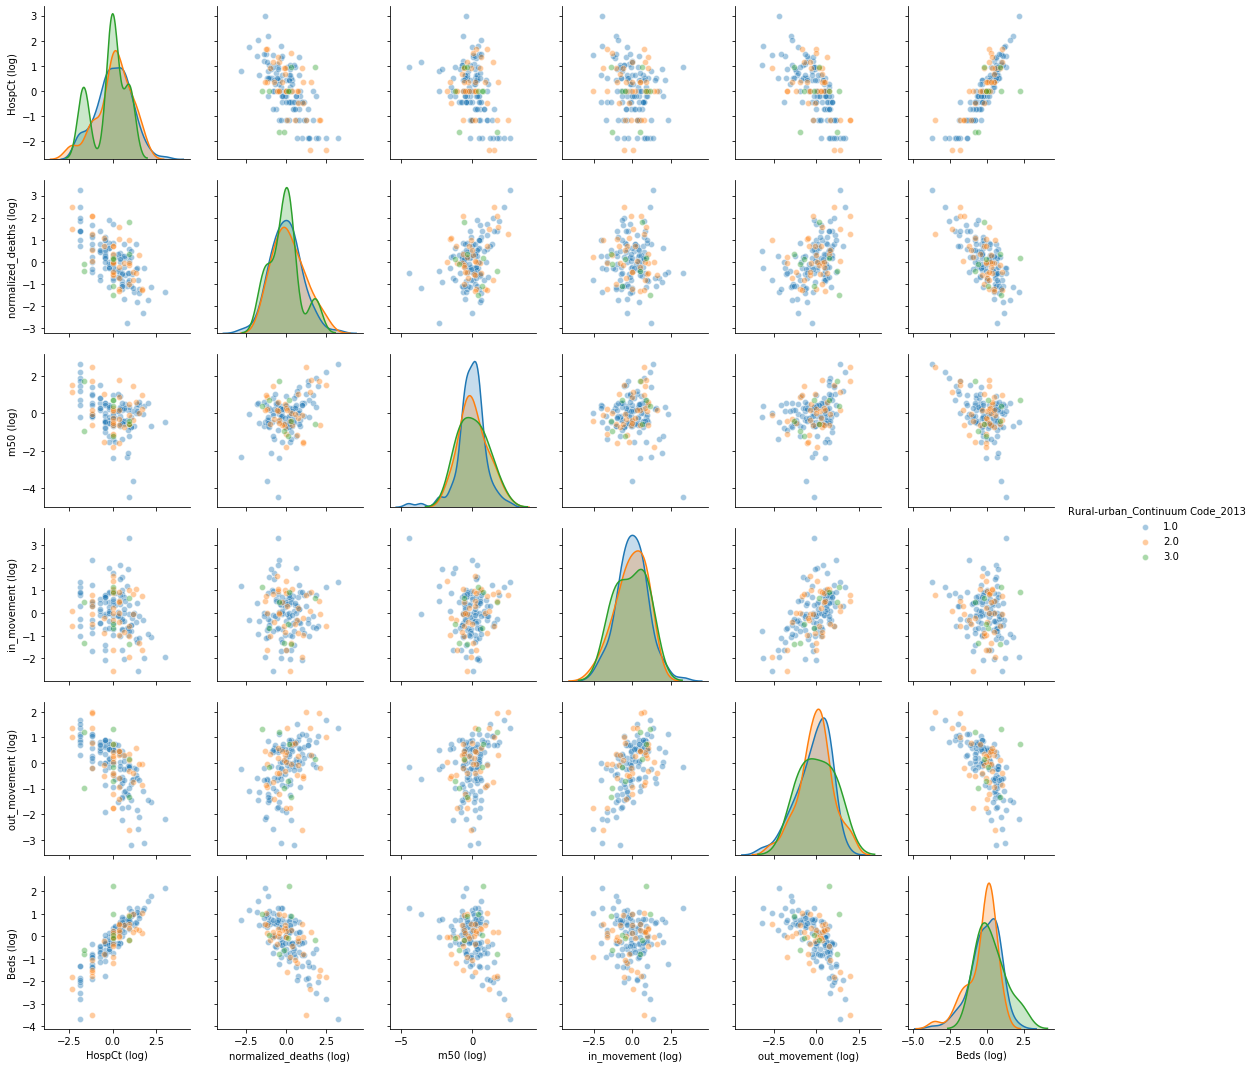

In [93]:
## Normalize each RUCC region by its mean and std
temp = pd.concat([
    cum_deaths['Rural-urban_Continuum Code_2013'],
    cum_deaths.groupby(
        'Rural-urban_Continuum Code_2013').transform(lambda x: (x - x.median()) / x.std()
        )
    ], axis=1)
temp.dropna(axis=0, inplace=True)
## Plot as before with the prior normalization
cols = ['HospCt (log)',
        'normalized_deaths (log)',
        'Beds (log)',
        'm50 (log)',
        'inter_movement (log)'
        'in_movement (log)',
        'out_movement (log)',
]
hue = 'Rural-urban_Continuum Code_2013'
sns.pairplot(temp, vars=cols, diag_kind='auto', hue=hue, plot_kws={'alpha': 0.4})

## With Matthias Clusters

In [86]:
m_clust = load_matthias_clusters()

In [87]:
cum_deaths = pd.merge(cum_deaths, m_clust, on='FIPS')


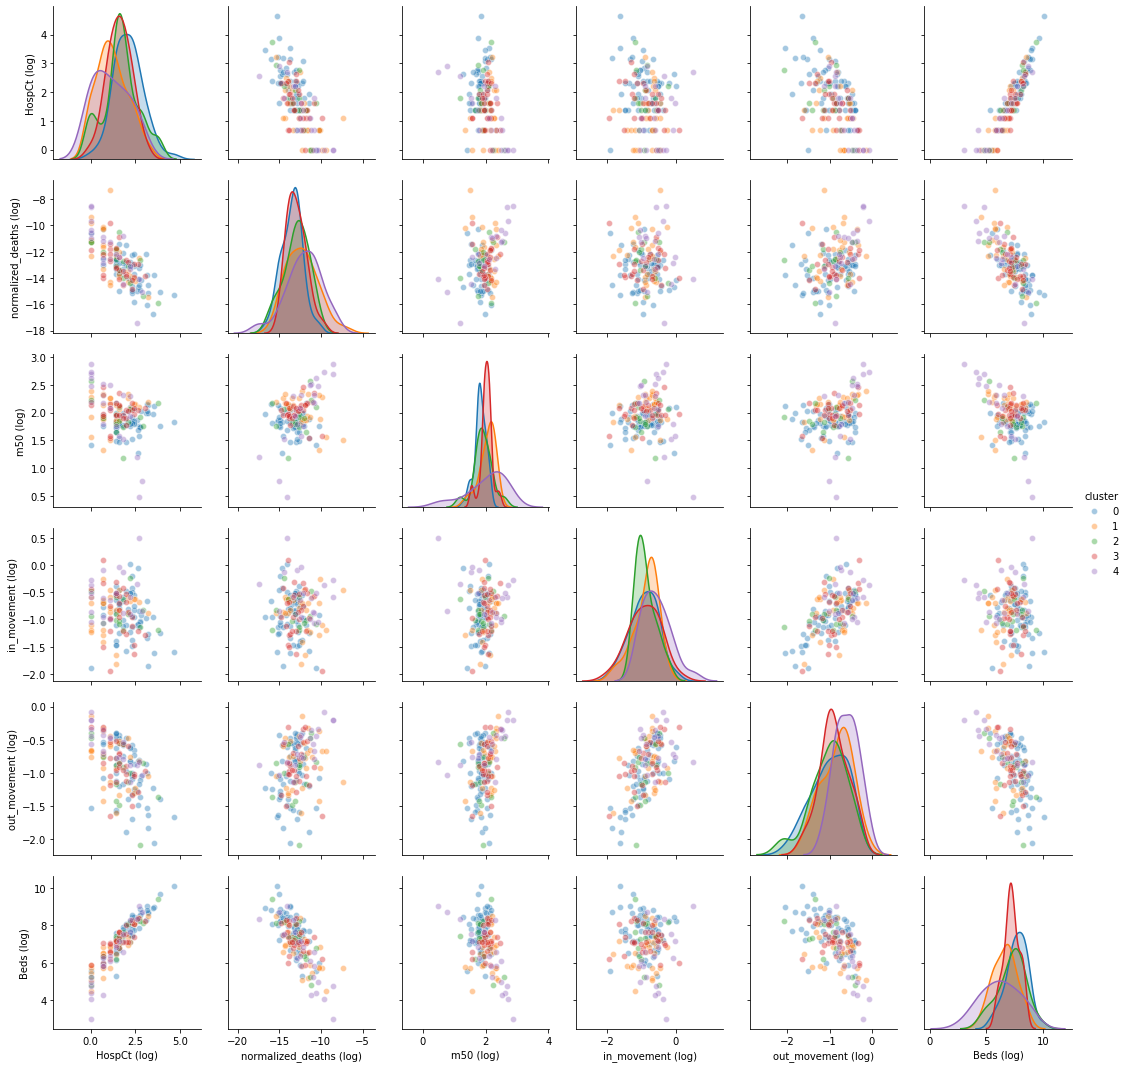

In [95]:
cols = ['HospCt (log)',
        'normalized_deaths (log)',
        'm50 (log)',
        'in_movement (log)',
        'out_movement (log)',
        'Beds (log)',
]
hue = 'cluster'
## Normalize each RUCC region by its mean and std
temp = pd.concat([
    cum_deaths['Rural-urban_Continuum Code_2013'],
    cum_deaths[hue],
    cum_deaths.groupby(
        'Rural-urban_Continuum Code_2013'
        )[cols].transform(lambda x: x#(x - x.median()) / x.std()
    )
    ], axis=1)
temp.dropna(axis=0, inplace=True)
## Plot as before with the prior normalization
sns.pairplot(temp, vars=cols, diag_kind='auto', hue=hue, plot_kws={'alpha': 0.4})